In [1]:
import os
import sys

from dotenv import load_dotenv
load_dotenv()

# os.environ['HF_HOME']="/Users/nikhil20.sharma/Desktop/langchain/.cache"

# Print all environment variables loaded from .env
print("Loaded Environment Variables:")
for key, value in os.environ.items():
    if key in ['OPENAI_API_KEY', 'LANGSMITH_AIP_KEY', 'HUGGINGFACE_TOKEN']:
        # Mask sensitive values for security
        masked_value = value[:8] + "..." + value[-4:] if value else value
        print(f"- {key}: {masked_value}")

Loaded Environment Variables:
- OPENAI_API_KEY: sk-proj-...znMA
- LANGSMITH_AIP_KEY: lsv2_pt_...4996


In [ ]:
import re
import time
import nltk
import sqlite3
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from pprint import pprint
from functools import wraps
import ipywidgets as widgets
from collections import Counter
import matplotlib.pyplot as plt
from IPython.display import display
from langchain_openai import ChatOpenAI
from nltk.tokenize import RegexpTokenizer
from wordcloud import WordCloud, STOPWORDS
from langchain_ollama.llms import OllamaLLM
from langchain.schema.document import Document
from langchain_chroma.vectorstores import Chroma
from langchain.prompts import ChatPromptTemplate
from nltk.sentiment import SentimentIntensityAnalyzer
from langchain_ollama.embeddings import OllamaEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter



## Extracting relavant information from the data

In [3]:
email_df = pd.read_csv('/Users/nikhil20.sharma/Downloads/emails.csv')
email_df.shape

(517401, 2)

In [4]:
email_df

,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...
...,...,...
517396,zufferli-j/sent_items/95.,Message-ID: <26807948.1075842029936.JavaMail.e...
517397,zufferli-j/sent_items/96.,Message-ID: <25835861.1075842029959.JavaMail.e...
517398,zufferli-j/sent_items/97.,Message-ID: <28979867.1075842029988.JavaMail.e...
517399,zufferli-j/sent_items/98.,Message-ID: <22052556.1075842030013.JavaMail.e...


In [5]:
df_copy = email_df.sample(100000)
# df_copy = email_df.copy()
df_copy.reset_index(drop=True, inplace=True)

In [6]:
df_copy.head()

,file,message
0,neal-s/_sent_mail/479.,Message-ID: <8518242.1075858433705.JavaMail.ev...
1,lay-k/discussion_threads/764.,Message-ID: <6154282.1075840251419.JavaMail.ev...
2,dasovich-j/mba_program/54.,Message-ID: <9769071.1075843087251.JavaMail.ev...
3,dasovich-j/all_documents/3173.,Message-ID: <28238224.1075843022815.JavaMail.e...
4,jones-t/all_documents/2808.,Message-ID: <4261666.1075846979387.JavaMail.ev...


In [7]:
# Create a dropdown widget with row numbers as options
# row_numbers = list(range(len(df)))
row_numbers = range(50)
dropdown = widgets.Dropdown(options=row_numbers, description='Select Row:')

# Create an output widget to display the message
output = widgets.Output()

# Define a function to update the output when the dropdown value changes
def update_output(change):
    with output:
        output.clear_output()
        selected_row = change.new
        message = email_df.iloc[selected_row]['message']
        print(message)

# Link the dropdown's value to the update_output function
dropdown.observe(update_output, names='value')

# Display the widgets
display(dropdown, output)

Dropdown(description='Select Row:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,…

Output()

| Header Field          | Value                                                                 | Description                                                                                                |
| --------------------- | --------------------------------------------------------------------- | ---------------------------------------------------------------------------------------------------------- |
| Message-ID            | `<16254169.1075863688286.JavaMail.evans@thyme>`                      | Unique identifier for the email.                                                                           |
| Date                  | `Tue, 22 Aug 2000 07:44:00 -0700 (PDT)`                             | Date and time the email was sent (Pacific Daylight Time).                                                    |
| From                  | `phillip.allen@enron.com`                                             | Sender's email address.                                                                                    |
| To                    | `david.l.johnson@enron.com, john.shafer@enron.com`                    | Recipients' email addresses.                                                                               |
| Subject               | (Empty)                                                               | The email has no subject.                                                                                  |
| Mime-Version          | `1.0`                                                                 | Indicates that the email uses MIME standard.                                                               |
| Content-Type          | `text/plain; charset=us-ascii`                                        | Specifies that the email content is plain text using the US-ASCII character set.                             |
| Content-Transfer-Encoding | `7bit`                                                              | Indicates the encoding used to transmit the content (7-bit encoding).                                       |
| X-From, X-To          | Varies                                                              | Non-standard headers providing sender and recipient information.                                          |
| X-cc, X-bcc           | (Empty)                                                               | No carbon copy or blind carbon copy recipients.                                                             |
| X-Folder              | `\Phillip_Allen_Dec2000\Notes Folders\'sent mail`                    | Indicates the folder where the email is stored in the sender's email client.                               |
| X-Origin              | `Allen-P`                                                             | Specifies the origin of the email (likely the sender's computer).                                          |
| X-FileName            | `pallen.nsf`                                                            | The name of the file where the email is stored.                                                            |
| **Summary**           |                                                                       | Email header information; the actual message body is missing.                                                |

In [ ]:
def extract_email_details(df):
    """
    Extracts email details like Message-ID, Date, From, To, etc., from the 'message' column of a DataFrame.

    Args:
        df (pd.DataFrame): DataFrame containing a 'message' column with email content.

    Returns:
        pd.DataFrame: DataFrame with extracted email details in new columns.
    """

    def extract_header(message, header_name):
        """Extracts the value of a specific header from the email message."""
        pattern = re.compile(f"{header_name}: (.*?)(?=\\n[A-Za-z-]|\\Z)", re.DOTALL)
        match = pattern.search(message)
        if match:
            return match.group(1).strip()
        return None

    df['Message-ID'] = df['message'].apply(lambda x: extract_header(x, 'Message-ID'))
    df['Date'] = df['message'].apply(lambda x: extract_header(x, 'Date'))
    df['From'] = df['message'].apply(lambda x: extract_header(x, 'From'))
    df['To'] = df['message'].apply(lambda x: extract_header(x, 'To'))
    df['To-count'] = df['To'].apply(lambda x: len(x.split(',')))
    df['Subject'] = df['message'].apply(lambda x: extract_header(x, 'Subject'))
    df['Content-Type'] = df['message'].apply(lambda x: extract_header(x, 'Content-Type'))
    df['Content-Transfer-Encoding'] = df['message'].apply(lambda x: extract_header(x, 'Content-Transfer-Encoding'))
    df['X-From'] = df['message'].apply(lambda x: extract_header(x, 'X-From'))
    df['X-To'] = df['message'].apply(lambda x: extract_header(x, 'X-To'))
    df['X-cc'] = df['message'].apply(lambda x: extract_header(x, 'X-cc'))
    df['X-bcc'] = df['message'].apply(lambda x: extract_header(x, 'X-bcc'))
    df['X-Folder'] = df['message'].apply(lambda x: extract_header(x, 'X-Folder'))
    df['X-Origin'] = df['message'].apply(lambda x: extract_header(x, 'X-Origin'))
    df['X-FileName'] = df['message'].apply(lambda x: extract_header(x, 'X-FileName'))

    # Identify and mark replies, and remove "Re:" from subject
    df['Reply'] = df['Subject'].apply(lambda x: 1 if x and re.match(r'^Re:.*', str(x), re.IGNORECASE) else 0)
    df['Subject'] = df['Subject'].apply(lambda x: re.sub(r'^Re:\s*', '', str(x), flags=re.IGNORECASE) if x else x)

    # Extract the domain from Message-ID
    def extract_domain(message_id):
        if message_id:
            try:
                return message_id.split('@')[1].replace('>', '')
            except IndexError:
                return None
        return None

    df['Message-ID-Domain'] = df['Message-ID'].apply(extract_domain)

    # Convert 'Date' column to datetime, handling potential errors
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce', utc=True)

    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['Year'] = df['Date'].dt.year
    df['Hour'] = df['Date'].dt.hour
    df['Minute'] = df['Date'].dt.minute
    df['Date'] = df['Date'].dt.date

    def extract_body(message):
        """Extracts the email body from the message."""
        # Split the message into header and body based on the first empty line
        parts = message.split('\n\n', 1)
        if len(parts) > 1:
            return parts[1].strip()
        return None  # Or return the original message if no body is found

    df['Body'] = df['message'].apply(extract_body)

    # Extract Lavel from the X-Folder
    df['Label'] = df['X-Folder'].apply(lambda x: x.split('\\')[-1] if x else None)

    return df

# Apply the function to your DataFrame
df = extract_email_details(df_copy)

/var/folders/2c/20w7d9vd7j3dtcqrsx02ml4r9h83hx/T/ipykernel_47934/50121508.py:56: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'], errors='coerce', utc=True)


In [ ]:
# Create a dropdown widget with row numbers as options
row_numbers = list(range(len(df)))
dropdown_row = widgets.Dropdown(options=row_numbers, description='Select Row:')

# Create a dropdown widget with column names as options
col_names = df.columns.tolist()
dropdown_col = widgets.Dropdown(options=col_names, description='Select Column:')

# Create an output widget to display the message
output = widgets.Output()

# Define a function to update the output when either dropdown value changes
def update_output(change):
    with output:
        output.clear_output()
        selected_row = dropdown_row.value
        selected_col = dropdown_col.value
        try:
            cell_value = df.loc[selected_row, selected_col]
            print()
            print()
            print(cell_value)

            # Calculate and display null count for the selected column
            null_count = df[selected_col].isnull().sum()
            print(f"\nNull count in column '{selected_col}': {null_count}")

            # Calculate and display duplicate count for the selected column
            duplicate_count = df[selected_col].duplicated().sum()
            print(f"Duplicate count in column '{selected_col}': {duplicate_count}")

        except KeyError:
            print("Invalid row or column selection.")

# Link the dropdown's value to the update_output function
dropdown_row.observe(update_output, names='value')
dropdown_col.observe(update_output, names='value')

# Display the widgets
display(dropdown_row, dropdown_col, output)

Dropdown(description='Select Row:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,…

Dropdown(description='Select Column:', options=('file', 'message', 'Message-ID', 'Date', 'From', 'To', 'To-cou…

Output()

In [8]:
df

,file,message,Message-ID,Date,From,To,To-count,Subject,Content-Type,Content-Transfer-Encoding,...,X-FileName,Reply,Message-ID-Domain,Day,Month,Year,Hour,Minute,Body,Label
0,neal-s/_sent_mail/479.,Message-ID: <8518242.1075858433705.JavaMail.ev...,<8518242.1075858433705.JavaMail.evans@thyme>,2000-06-14,scott.neal@enron.com,sandra.brawner@enron.com,1,Gas Position Report - Executive Reports Viewer,text/plain; charset=us-ascii,7bit,...,sneal.nsf,0,thyme,14,6,2000,16,23,---------------------- Forwarded by Scott Neal...,'sent mail
1,lay-k/discussion_threads/764.,Message-ID: <6154282.1075840251419.JavaMail.ev...,<6154282.1075840251419.JavaMail.evans@thyme>,2000-11-28,connie.blackwood@enron.com,"rebecca.mcdonald@enron.com, wade.cline@enron.c...",5,DPC Selldown Meeting,text/plain; charset=us-ascii,7bit,...,klay.nsf,0,thyme,28,11,2000,8,25,The location of the above referenced meeting s...,Discussion threads
2,dasovich-j/mba_program/54.,Message-ID: <9769071.1075843087251.JavaMail.ev...,<9769071.1075843087251.JavaMail.evans@thyme>,1999-10-01,spoyneer@haas.berkeley.edu,eveningmba@haas.berkeley.edu,1,Your Input Please,text/plain; charset=us-ascii,7bit,...,jdasovic.nsf,0,thyme,1,10,1999,4,46,What library/information services do you need ...,Mba program
3,dasovich-j/all_documents/3173.,Message-ID: <28238224.1075843022815.JavaMail.e...,<28238224.1075843022815.JavaMail.evans@thyme>,2000-11-07,roger.yang@enron.com,"tamara.johnson@enron.com, marcie.milner@enron....",6,California Rate Changes,text/plain; charset=us-ascii,7bit,...,jdasovic.nsf,0,thyme,7,11,2000,17,49,Attached is a file that has tracked the rate c...,All documents
4,jones-t/all_documents/2808.,Message-ID: <4261666.1075846979387.JavaMail.ev...,<4261666.1075846979387.JavaMail.evans@thyme>,2000-07-25,tana.jones@enron.com,"alan.aronowitz@enron.com, jeffrey.hodge@enron....",10,RUSH APPROVAL-Australia + Japan Weather,text/plain; charset=us-ascii,7bit,...,tjones.nsf,0,thyme,25,7,2000,9,53,Below is a RUSH list that we need to approve b...,All documents
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,kaminski-v/all_documents/10999.,Message-ID: <32421707.1075856785249.JavaMail.e...,<32421707.1075856785249.JavaMail.evans@thyme>,2000-01-05,stinson.gibner@enron.com,information.management@enron.com,1,revision of 1st request,text/plain; charset=us-ascii,7bit,...,vkamins.nsf,1,thyme,5,1,2000,8,44,I approve of the attached request.\n--Stinson ...,All documents
99996,harris-s/deleted_items/528.,Message-ID: <20657399.1075862338286.JavaMail.e...,<20657399.1075862338286.JavaMail.evans@thyme>,2001-11-27,jhairsmd@aol.com,steven.harris@enron.com,1,,text/plain; charset=us-ascii,7bit,...,SHARRIS1 (Non-Privileged).pst,1,thyme,27,11,2001,20,57,"hey steve, \ni guess the good news is that you...",Deleted Items
99997,hernandez-j/discussion_threads/54.,Message-ID: <32389951.1075851844784.JavaMail.e...,<32389951.1075851844784.JavaMail.evans@thyme>,2001-01-02,bible-html@emazing.com,bible-html@emazing.com,1,EMAZING Bible Verse of the Day - Colossians 3:12,text/plain; charset=ANSI_X3.4-1968,quoted-printable,...,jhernan.nsf\n\n=09=09EMAZING Home[IMAGE]Edit Y...,0,thyme,2,1,2001,13,50,=09=09EMAZING Home[IMAGE]Edit Your ProfilePriv...,Discussion threads
99998,taylor-m/notes_inbox/1240.,Message-ID: <18711702.1075860012648.JavaMail.e...,<18711702.1075860012648.JavaMail.evans@thyme>,2000-08-21,bob.shults@enron.com,mark.taylor@enron.com,1,EnronOnline Pilot Program,text/plain; charset=us-ascii,7bit,...,mtaylor.nsf,0,thyme,21,8,2000,14,20,We have finalized the terms of the EnronOnline...,Notes inbox


In [9]:
df.head(1).T

,0
file,neal-s/_sent_mail/479.
message,Message-ID: <8518242.1075858433705.JavaMail.ev...
Message-ID,<8518242.1075858433705.JavaMail.evans@thyme>
Date,2000-06-14
From,scott.neal@enron.com
To,sandra.brawner@enron.com
To-count,1
Subject,Gas Position Report - Executive Reports Viewer
Content-Type,text/plain; charset=us-ascii
Content-Transfer-Encoding,7bit


In [10]:
selected_columns = [
    'Date',
    'From',
    'To',
    'Subject',
    'Content-Type',
    'Content-Transfer-Encoding',
    'Reply',
    'Day',
    'Month',
    'Year',
    'Hour',
    'Minute',
    'To-count',
    'Body',
    'Label'
]

In [11]:
df = df[selected_columns]

In [12]:
df

,Date,From,To,Subject,Content-Type,Content-Transfer-Encoding,Reply,Day,Month,Year,Hour,Minute,To-count,Body,Label
0,2000-06-14,scott.neal@enron.com,sandra.brawner@enron.com,Gas Position Report - Executive Reports Viewer,text/plain; charset=us-ascii,7bit,0,14,6,2000,16,23,1,---------------------- Forwarded by Scott Neal...,'sent mail
1,2000-11-28,connie.blackwood@enron.com,"rebecca.mcdonald@enron.com, wade.cline@enron.c...",DPC Selldown Meeting,text/plain; charset=us-ascii,7bit,0,28,11,2000,8,25,5,The location of the above referenced meeting s...,Discussion threads
2,1999-10-01,spoyneer@haas.berkeley.edu,eveningmba@haas.berkeley.edu,Your Input Please,text/plain; charset=us-ascii,7bit,0,1,10,1999,4,46,1,What library/information services do you need ...,Mba program
3,2000-11-07,roger.yang@enron.com,"tamara.johnson@enron.com, marcie.milner@enron....",California Rate Changes,text/plain; charset=us-ascii,7bit,0,7,11,2000,17,49,6,Attached is a file that has tracked the rate c...,All documents
4,2000-07-25,tana.jones@enron.com,"alan.aronowitz@enron.com, jeffrey.hodge@enron....",RUSH APPROVAL-Australia + Japan Weather,text/plain; charset=us-ascii,7bit,0,25,7,2000,9,53,10,Below is a RUSH list that we need to approve b...,All documents
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2000-01-05,stinson.gibner@enron.com,information.management@enron.com,revision of 1st request,text/plain; charset=us-ascii,7bit,1,5,1,2000,8,44,1,I approve of the attached request.\n--Stinson ...,All documents
99996,2001-11-27,jhairsmd@aol.com,steven.harris@enron.com,,text/plain; charset=us-ascii,7bit,1,27,11,2001,20,57,1,"hey steve, \ni guess the good news is that you...",Deleted Items
99997,2001-01-02,bible-html@emazing.com,bible-html@emazing.com,EMAZING Bible Verse of the Day - Colossians 3:12,text/plain; charset=ANSI_X3.4-1968,quoted-printable,0,2,1,2001,13,50,1,=09=09EMAZING Home[IMAGE]Edit Your ProfilePriv...,Discussion threads
99998,2000-08-21,bob.shults@enron.com,mark.taylor@enron.com,EnronOnline Pilot Program,text/plain; charset=us-ascii,7bit,0,21,8,2000,14,20,1,We have finalized the terms of the EnronOnline...,Notes inbox


## Data Exploration and cleaning

In [14]:
df.Year.value_counts()

Year
2001    52761
2000    37791
2002     7061
1999     2156
1980      103
1997       79
1998       33
2004       13
2044        1
2007        1
2012        1
Name: count, dtype: int64

In [15]:
df['Content-Type'].value_counts()

Content-Type
text/plain; charset=us-ascii          92589
text/plain; charset=ANSI_X3.4-1968     7411
Name: count, dtype: int64

In [16]:
df['Content-Transfer-Encoding'].value_counts()

Content-Transfer-Encoding
7bit                95652
quoted-printable     4348
Name: count, dtype: int64

In [17]:
# Replace empty strings with NaN
df['To'] = df['To'].replace('', np.nan)

# Drop rows where 'To' column is NaN
df = df.dropna(subset=['To'])

df.reset_index(drop=True, inplace=True)

/var/folders/2c/20w7d9vd7j3dtcqrsx02ml4r9h83hx/T/ipykernel_47934/3836247790.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['To'] = df['To'].replace('', np.nan)


In [18]:
df

,Date,From,To,Subject,Content-Type,Content-Transfer-Encoding,Reply,Day,Month,Year,Hour,Minute,To-count,Body,Label
0,2000-06-14,scott.neal@enron.com,sandra.brawner@enron.com,Gas Position Report - Executive Reports Viewer,text/plain; charset=us-ascii,7bit,0,14,6,2000,16,23,1,---------------------- Forwarded by Scott Neal...,'sent mail
1,2000-11-28,connie.blackwood@enron.com,"rebecca.mcdonald@enron.com, wade.cline@enron.c...",DPC Selldown Meeting,text/plain; charset=us-ascii,7bit,0,28,11,2000,8,25,5,The location of the above referenced meeting s...,Discussion threads
2,1999-10-01,spoyneer@haas.berkeley.edu,eveningmba@haas.berkeley.edu,Your Input Please,text/plain; charset=us-ascii,7bit,0,1,10,1999,4,46,1,What library/information services do you need ...,Mba program
3,2000-11-07,roger.yang@enron.com,"tamara.johnson@enron.com, marcie.milner@enron....",California Rate Changes,text/plain; charset=us-ascii,7bit,0,7,11,2000,17,49,6,Attached is a file that has tracked the rate c...,All documents
4,2000-07-25,tana.jones@enron.com,"alan.aronowitz@enron.com, jeffrey.hodge@enron....",RUSH APPROVAL-Australia + Japan Weather,text/plain; charset=us-ascii,7bit,0,25,7,2000,9,53,10,Below is a RUSH list that we need to approve b...,All documents
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98273,2000-01-05,stinson.gibner@enron.com,information.management@enron.com,revision of 1st request,text/plain; charset=us-ascii,7bit,1,5,1,2000,8,44,1,I approve of the attached request.\n--Stinson ...,All documents
98274,2001-11-27,jhairsmd@aol.com,steven.harris@enron.com,,text/plain; charset=us-ascii,7bit,1,27,11,2001,20,57,1,"hey steve, \ni guess the good news is that you...",Deleted Items
98275,2001-01-02,bible-html@emazing.com,bible-html@emazing.com,EMAZING Bible Verse of the Day - Colossians 3:12,text/plain; charset=ANSI_X3.4-1968,quoted-printable,0,2,1,2001,13,50,1,=09=09EMAZING Home[IMAGE]Edit Your ProfilePriv...,Discussion threads
98276,2000-08-21,bob.shults@enron.com,mark.taylor@enron.com,EnronOnline Pilot Program,text/plain; charset=us-ascii,7bit,0,21,8,2000,14,20,1,We have finalized the terms of the EnronOnline...,Notes inbox


In [19]:
label = (df['Label'].value_counts().to_frame()/100000)*100
label.reset_index(inplace=True)

In [20]:
label

,Label,count
0,All documents,24.386
1,Discussion threads,11.167
2,Sent,10.962
3,Deleted Items,9.674
4,Inbox,7.983
...,...,...
1351,Budget - 2002,0.001
1352,Non-US offices,0.001
1353,Customer - MidAm,0.001
1354,CASH,0.001


In [ ]:
def correct_labels(label):
    """
    Categorizes email labels based on keywords.

    Args:
        label (str): The email label to categorize.

    Returns:
        str: The corrected label.
    """
    if isinstance(label, str):  # Check if label is a string
        label_lower = label.lower()
        if 'documents' in label_lower:
            return 'documents'
        elif 'threads' in label_lower:
            return 'threads'
        elif 'sent' in label_lower:
            return 'sent'
        elif 'inbox' in label_lower:
            return 'inbox'
        elif 'notes' in label_lower:
            return 'notes'
        else:
            return 'others'
    else:
        return 'others'  # Handle cases where label is None or NaN

df['Label'] = df['Label'].apply(correct_labels)

/var/folders/2c/20w7d9vd7j3dtcqrsx02ml4r9h83hx/T/ipykernel_47934/3577479058.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Label'] = df['Label'].apply(correct_labels)


In [23]:
df

,Date,From,To,Subject,Content-Type,Content-Transfer-Encoding,Reply,Day,Month,Year,Hour,Minute,To-count,Body,Label
0,2000-06-14,scott.neal@enron.com,sandra.brawner@enron.com,Gas Position Report - Executive Reports Viewer,text/plain; charset=us-ascii,7bit,0,14,6,2000,16,23,1,---------------------- Forwarded by Scott Neal...,sent
1,2000-11-28,connie.blackwood@enron.com,"rebecca.mcdonald@enron.com, wade.cline@enron.c...",DPC Selldown Meeting,text/plain; charset=us-ascii,7bit,0,28,11,2000,8,25,5,The location of the above referenced meeting s...,threads
2,1999-10-01,spoyneer@haas.berkeley.edu,eveningmba@haas.berkeley.edu,Your Input Please,text/plain; charset=us-ascii,7bit,0,1,10,1999,4,46,1,What library/information services do you need ...,others
3,2000-11-07,roger.yang@enron.com,"tamara.johnson@enron.com, marcie.milner@enron....",California Rate Changes,text/plain; charset=us-ascii,7bit,0,7,11,2000,17,49,6,Attached is a file that has tracked the rate c...,documents
4,2000-07-25,tana.jones@enron.com,"alan.aronowitz@enron.com, jeffrey.hodge@enron....",RUSH APPROVAL-Australia + Japan Weather,text/plain; charset=us-ascii,7bit,0,25,7,2000,9,53,10,Below is a RUSH list that we need to approve b...,documents
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98273,2000-01-05,stinson.gibner@enron.com,information.management@enron.com,revision of 1st request,text/plain; charset=us-ascii,7bit,1,5,1,2000,8,44,1,I approve of the attached request.\n--Stinson ...,documents
98274,2001-11-27,jhairsmd@aol.com,steven.harris@enron.com,,text/plain; charset=us-ascii,7bit,1,27,11,2001,20,57,1,"hey steve, \ni guess the good news is that you...",others
98275,2001-01-02,bible-html@emazing.com,bible-html@emazing.com,EMAZING Bible Verse of the Day - Colossians 3:12,text/plain; charset=ANSI_X3.4-1968,quoted-printable,0,2,1,2001,13,50,1,=09=09EMAZING Home[IMAGE]Edit Your ProfilePriv...,threads
98276,2000-08-21,bob.shults@enron.com,mark.taylor@enron.com,EnronOnline Pilot Program,text/plain; charset=us-ascii,7bit,0,21,8,2000,14,20,1,We have finalized the terms of the EnronOnline...,inbox


In [25]:
df.Label.value_counts()

Label
documents    24404
sent         24268
others       23351
inbox        15088
threads      11167
Name: count, dtype: int64

In [27]:
df[df['Subject']=='']

,Date,From,To,Subject,Content-Type,Content-Transfer-Encoding,Reply,Day,Month,Year,Hour,Minute,To-count,Body,Label
5,2001-01-05,debra.perlingiere@enron.com,"jeffrey.hodge@enron.com, dan.hyvl@enron.com",,text/plain; charset=us-ascii,7bit,0,5,1,2001,18,1,2,Due to a doctors appointment Monday morning I...,sent
11,2000-12-12,vince.kaminski@enron.com,vkaminski@aol.com,,text/plain; charset=us-ascii,7bit,0,12,12,2000,17,9,1,B&C\n\n800 357 4410 ext 6422 Amy regardi...,threads
39,2001-09-26,jeff.dasovich@enron.com,7409949@skytel.com,,text/plain; charset=us-ascii,7bit,0,26,9,2001,16,3,1,"If u and others are trying to get on CA call, ...",sent
51,2000-06-07,chris.germany@enron.com,1117083@PageNetHou,,text/plain; charset=us-ascii,7bit,0,7,6,2000,13,13,1,Test. Does this work?,documents
78,2000-09-07,john.lavorato@enron.com,david.oxley@enron.com,,text/plain; charset=us-ascii,7bit,0,7,9,2000,7,36,1,Dave\n\nAs part of the info you should put tog...,sent
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98203,2002-03-21,joe.parks@enron.com,parks_kim@da.co.harris.tx.us,,text/plain; charset=us-ascii,7bit,0,21,3,2002,14,34,1,got a call from duke. They filled the position.,sent
98232,2001-11-13,jeff.dasovich@enron.com,eldon@direcpc.com,,text/plain; charset=us-ascii,7bit,0,13,11,2001,1,2,1,do you have rory's email address?,sent
98252,2001-08-21,chris.dorland@enron.com,mike.cowan@enron.com,,text/plain; charset=us-ascii,7bit,0,21,8,2001,14,12,1,What are the details of this offsite? Make sur...,sent
98262,2001-10-08,dutch.quigley@enron.com,amanda.huble@enron.com,,text/plain; charset=us-ascii,7bit,1,8,10,2001,17,0,1,yummmmmmmmmmmmmmmmmmmmmm\n\n -----Original Mes...,sent


In [ ]:
def clean_email_body(text):
    # Remove line breaks and reduce multiple whitespaces to a single space
    text = re.sub(r'\s+', ' ', text)
    # Remove unwanted special characters but keep "/" and ":" to preserve dates and times
    text = re.sub(r'[^\w\s/:]', '', text)
    # Convert text to lower case for consistency
    text = text.lower()
    return text

# # Clean the 'Body' column
df['Cleaned_Body'] = df['Body'].apply(clean_email_body)
df['Body_length'] = df['Body'].apply(lambda x: len(str(x)))

/var/folders/2c/20w7d9vd7j3dtcqrsx02ml4r9h83hx/T/ipykernel_47934/1084616036.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Body_length'] = df['Body'].apply(lambda x: len(str(x)))


In [69]:
df

,Date,From,To,Subject,Content-Type,Content-Transfer-Encoding,Reply,Day,Month,Year,Hour,Minute,To-count,Body,Label,Cleaned_Body,Body_length
0,2000-06-14,scott.neal@enron.com,sandra.brawner@enron.com,Gas Position Report - Executive Reports Viewer,text/plain; charset=us-ascii,7bit,0,14,6,2000,16,23,1,---------------------- Forwarded by Scott Neal...,sent,forwarded by scott neal/hou/ect on 06/14/2000...,1227
1,2000-11-28,connie.blackwood@enron.com,"rebecca.mcdonald@enron.com, wade.cline@enron.c...",DPC Selldown Meeting,text/plain; charset=us-ascii,7bit,0,28,11,2000,8,25,5,The location of the above referenced meeting s...,threads,the location of the above referenced meeting s...,323
2,1999-10-01,spoyneer@haas.berkeley.edu,eveningmba@haas.berkeley.edu,Your Input Please,text/plain; charset=us-ascii,7bit,0,1,10,1999,4,46,1,What library/information services do you need ...,others,what library/information services do you need ...,755
3,2000-11-07,roger.yang@enron.com,"tamara.johnson@enron.com, marcie.milner@enron....",California Rate Changes,text/plain; charset=us-ascii,7bit,0,7,11,2000,17,49,6,Attached is a file that has tracked the rate c...,documents,attached is a file that has tracked the rate c...,618
4,2000-07-25,tana.jones@enron.com,"alan.aronowitz@enron.com, jeffrey.hodge@enron....",RUSH APPROVAL-Australia + Japan Weather,text/plain; charset=us-ascii,7bit,0,25,7,2000,9,53,10,Below is a RUSH list that we need to approve b...,documents,below is a rush list that we need to approve b...,1201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98273,2000-01-05,stinson.gibner@enron.com,information.management@enron.com,revision of 1st request,text/plain; charset=us-ascii,7bit,1,5,1,2000,8,44,1,I approve of the attached request.\n--Stinson ...,documents,i approve of the attached request stinson gibn...,1456
98274,2001-11-27,jhairsmd@aol.com,steven.harris@enron.com,,text/plain; charset=us-ascii,7bit,1,27,11,2001,20,57,1,"hey steve, \ni guess the good news is that you...",others,hey steve i guess the good news is that you st...,1322
98275,2001-01-02,bible-html@emazing.com,bible-html@emazing.com,EMAZING Bible Verse of the Day - Colossians 3:12,text/plain; charset=ANSI_X3.4-1968,quoted-printable,0,2,1,2001,13,50,1,=09=09EMAZING Home[IMAGE]Edit Your ProfilePriv...,threads,0909emazing homeimageedit your profileprivacy ...,3370
98276,2000-08-21,bob.shults@enron.com,mark.taylor@enron.com,EnronOnline Pilot Program,text/plain; charset=us-ascii,7bit,0,21,8,2000,14,20,1,We have finalized the terms of the EnronOnline...,inbox,we have finalized the terms of the enrononline...,1814


In [ ]:
tokenizer = RegexpTokenizer(r'\w+')
df['Body_tokenized'] = df['Cleaned_Body'].apply(tokenizer.tokenize)

/var/folders/2c/20w7d9vd7j3dtcqrsx02ml4r9h83hx/T/ipykernel_47934/4150252645.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Body_tokenized'] = df['Cleaned_Body'].apply(tokenizer.tokenize)


In [72]:
all_words = [word for tokens in df['Body_tokenized'] for word in tokens]
df['Body_tokenized_length'] = df['Body_tokenized'].apply(lambda x: len(str(x)))
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))

/var/folders/2c/20w7d9vd7j3dtcqrsx02ml4r9h83hx/T/ipykernel_47934/2199446418.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Body_tokenized_length'] = df['Body_tokenized'].apply(lambda x: len(str(x)))


25170683 words total, with a vocabulary size of 399781


In [73]:
df

,Date,From,To,Subject,Content-Type,Content-Transfer-Encoding,Reply,Day,Month,Year,Hour,Minute,To-count,Body,Label,Cleaned_Body,Body_length,Body_tokenized,Body_tokenized_length
0,2000-06-14,scott.neal@enron.com,sandra.brawner@enron.com,Gas Position Report - Executive Reports Viewer,text/plain; charset=us-ascii,7bit,0,14,6,2000,16,23,1,---------------------- Forwarded by Scott Neal...,sent,forwarded by scott neal/hou/ect on 06/14/2000...,1227,"[forwarded, by, scott, neal, hou, ect, on, 06,...",1671
1,2000-11-28,connie.blackwood@enron.com,"rebecca.mcdonald@enron.com, wade.cline@enron.c...",DPC Selldown Meeting,text/plain; charset=us-ascii,7bit,0,28,11,2000,8,25,5,The location of the above referenced meeting s...,threads,the location of the above referenced meeting s...,323,"[the, location, of, the, above, referenced, me...",438
2,1999-10-01,spoyneer@haas.berkeley.edu,eveningmba@haas.berkeley.edu,Your Input Please,text/plain; charset=us-ascii,7bit,0,1,10,1999,4,46,1,What library/information services do you need ...,others,what library/information services do you need ...,755,"[what, library, information, services, do, you...",1065
3,2000-11-07,roger.yang@enron.com,"tamara.johnson@enron.com, marcie.milner@enron....",California Rate Changes,text/plain; charset=us-ascii,7bit,0,7,11,2000,17,49,6,Attached is a file that has tracked the rate c...,documents,attached is a file that has tracked the rate c...,618,"[attached, is, a, file, that, has, tracked, th...",897
4,2000-07-25,tana.jones@enron.com,"alan.aronowitz@enron.com, jeffrey.hodge@enron....",RUSH APPROVAL-Australia + Japan Weather,text/plain; charset=us-ascii,7bit,0,25,7,2000,9,53,10,Below is a RUSH list that we need to approve b...,documents,below is a rush list that we need to approve b...,1201,"[below, is, a, rush, list, that, we, need, to,...",1495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98273,2000-01-05,stinson.gibner@enron.com,information.management@enron.com,revision of 1st request,text/plain; charset=us-ascii,7bit,1,5,1,2000,8,44,1,I approve of the attached request.\n--Stinson ...,documents,i approve of the attached request stinson gibn...,1456,"[i, approve, of, the, attached, request, stins...",1824
98274,2001-11-27,jhairsmd@aol.com,steven.harris@enron.com,,text/plain; charset=us-ascii,7bit,1,27,11,2001,20,57,1,"hey steve, \ni guess the good news is that you...",others,hey steve i guess the good news is that you st...,1322,"[hey, steve, i, guess, the, good, news, is, th...",2069
98275,2001-01-02,bible-html@emazing.com,bible-html@emazing.com,EMAZING Bible Verse of the Day - Colossians 3:12,text/plain; charset=ANSI_X3.4-1968,quoted-printable,0,2,1,2001,13,50,1,=09=09EMAZING Home[IMAGE]Edit Your ProfilePriv...,threads,0909emazing homeimageedit your profileprivacy ...,3370,"[0909emazing, homeimageedit, your, profilepriv...",4345
98276,2000-08-21,bob.shults@enron.com,mark.taylor@enron.com,EnronOnline Pilot Program,text/plain; charset=us-ascii,7bit,0,21,8,2000,14,20,1,We have finalized the terms of the EnronOnline...,inbox,we have finalized the terms of the enrononline...,1814,"[we, have, finalized, the, terms, of, the, enr...",2616


In [ ]:
# Checking most common words
count_all_words = Counter(all_words)
count_all_words.most_common(20)

[('the', 1007390),
 ('to', 728976),
 ('and', 461239),
 ('of', 414627),
 ('a', 352327),
 ('in', 303328),
 ('for', 263240),
 ('on', 223755),
 ('is', 222964),
 ('you', 217052),
 ('that', 194052),
 ('i', 188947),
 ('this', 167934),
 ('be', 156342),
 ('with', 138468),
 ('from', 137492),
 ('will', 136919),
 ('have', 129005),
 ('we', 126560),
 ('at', 126423)]

## Data Visualisation

In [28]:
df.columns

Index(['Date', 'From', 'To', 'Subject', 'Content-Type',
       'Content-Transfer-Encoding', 'Reply', 'Day', 'Month', 'Year', 'Hour',
       'Minute', 'To-count', 'Body', 'Label'],
      dtype='object')

/var/folders/2c/20w7d9vd7j3dtcqrsx02ml4r9h83hx/T/ipykernel_47934/3884145714.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Year', palette='viridis')


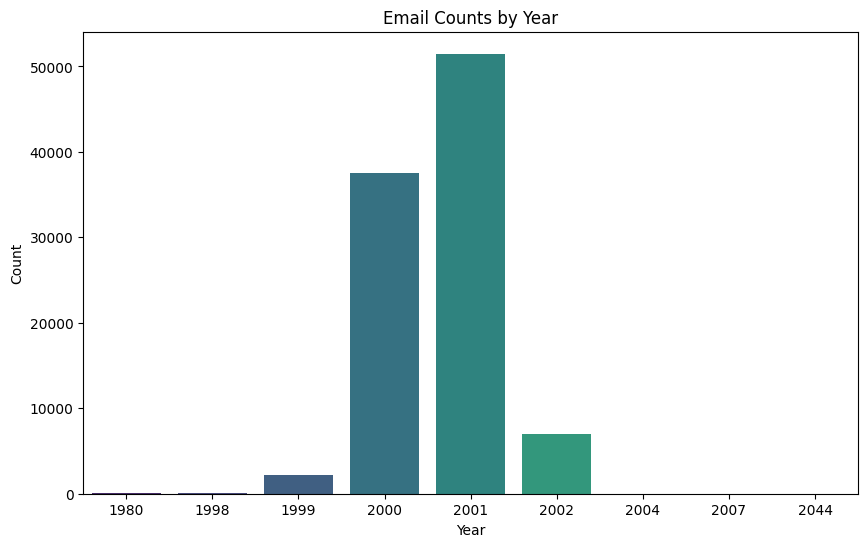

In [45]:
# --- 1. Emails by Year ---
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Year', palette='viridis')
plt.title("Email Counts by Year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.show()

/var/folders/2c/20w7d9vd7j3dtcqrsx02ml4r9h83hx/T/ipykernel_47934/1922390269.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Month', palette='viridis')


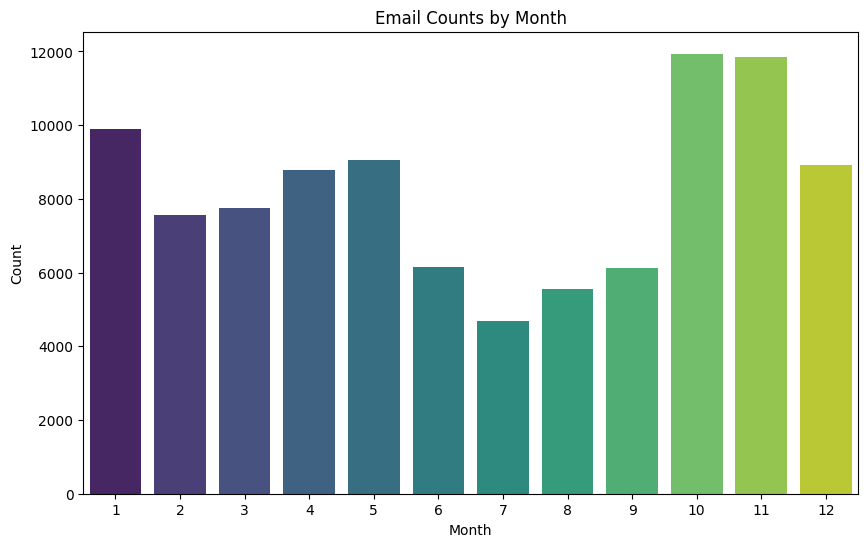

In [46]:
# --- 2. Emails by Month ---
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Month', palette='viridis')
plt.title("Email Counts by Month")
plt.xlabel("Month")
plt.ylabel("Count")
plt.show()

/var/folders/2c/20w7d9vd7j3dtcqrsx02ml4r9h83hx/T/ipykernel_47934/1018240183.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Hour', palette='viridis')


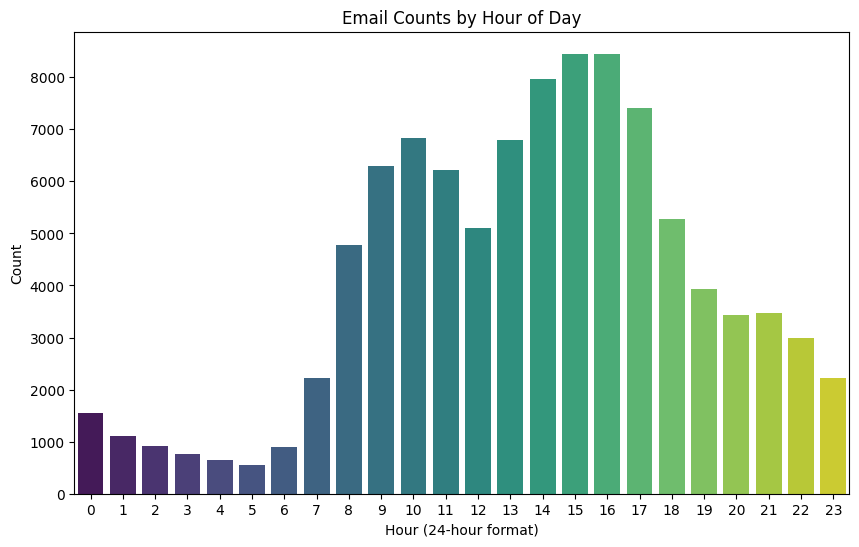

In [47]:
# --- 3. Emails by Hour of Day ---
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Hour', palette='viridis')
plt.title("Email Counts by Hour of Day")
plt.xlabel("Hour (24-hour format)")
plt.ylabel("Count")
plt.show()

/var/folders/2c/20w7d9vd7j3dtcqrsx02ml4r9h83hx/T/ipykernel_47934/3320034046.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_senders.index, y=top_senders.values, palette='viridis')


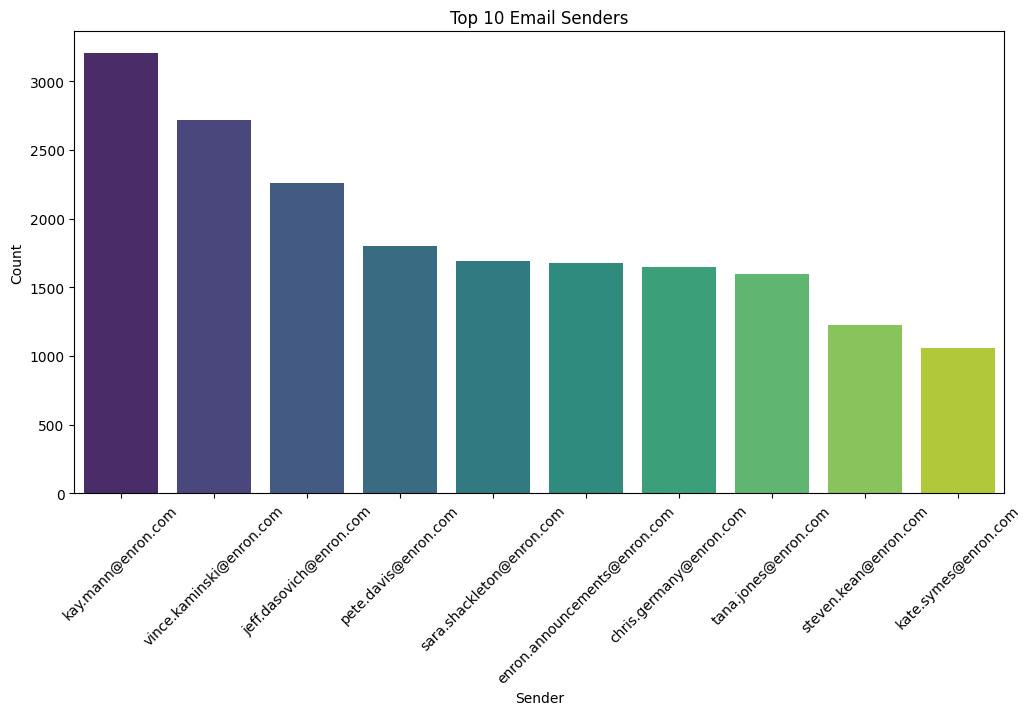

In [48]:
# --- 4. Top 10 Senders ---
top_senders = df['From'].value_counts().head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_senders.index, y=top_senders.values, palette='viridis')
plt.title("Top 10 Email Senders")
plt.xlabel("Sender")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

/var/folders/2c/20w7d9vd7j3dtcqrsx02ml4r9h83hx/T/ipykernel_47934/540354178.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Label', palette='viridis')


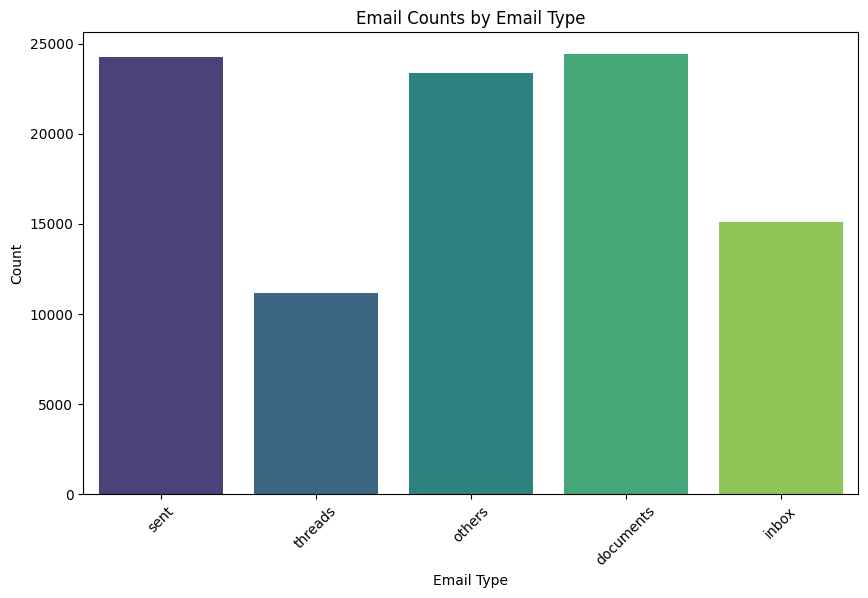

In [51]:
# --- 6. Emails by Email Type ---
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Label', palette='viridis')
plt.title("Email Counts by Email Type")
plt.xlabel("Email Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [80]:
df.columns

Index(['Date', 'From', 'To', 'Subject', 'Content-Type',
       'Content-Transfer-Encoding', 'Reply', 'Day', 'Month', 'Year', 'Hour',
       'Minute', 'To-count', 'Body', 'Label', 'Cleaned_Body', 'Body_length',
       'Body_tokenized', 'Body_tokenized_length'],
      dtype='object')

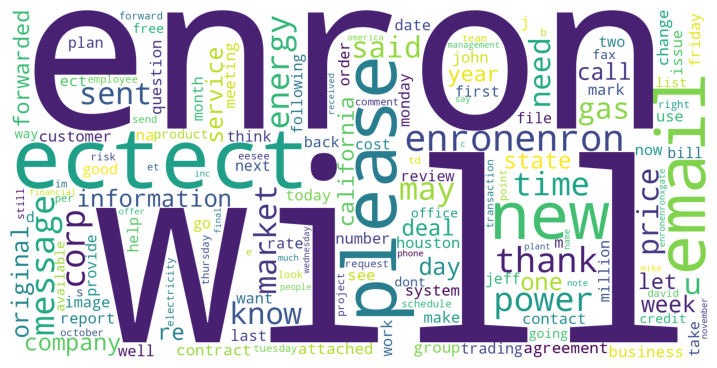

In [ ]:
stopwords = set(STOPWORDS)
to_add = ['FW', 'ga', 'httpitcappscorpenroncomsrrsauthemaillinkaspidpage', 'cc', 'aa', 'aaa', 'aaaa',
         'hou', 'cc', 'etc', 'subject', 'pm', 'will']

for i in to_add:
    stopwords.add(i)

# Visualise Email Subject
temp = df['Body_tokenized'].apply(lambda x: ' '.join(x))

wordcloud = WordCloud(
    collocations = False,
    width=1600, height=800,
    background_color='white',
    stopwords=stopwords,
    max_words=150,
    #max_font_size=40, 
    random_state=42
).generate(' '.join(temp.to_list()))

print(wordcloud)
plt.figure(figsize=(9,8))
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## ML Arena

With the current dataset we have scope to do the following especially 
- Classical ML approaches:
  - Sentiment Analysis
  - Topic Modelling
  - Emotion Analysis
  - Multi Class classification
  - Fraud/Spam analysis and classification
- Gen AI / LLM: **MAIN FOCUS**
  - All the above except Topic Modelling
  - QNA system, non tech person can interact with the data using day to day language
    - RAG Based
    - Agentic system

### 1. Sentiment Analysis -- Demo Example

In [67]:
# Download the VADER lexicon if you haven't already
try:
    model = SentimentIntensityAnalyzer()
except LookupError:
    nltk.download('vader_lexicon')
    model = SentimentIntensityAnalyzer()

In [68]:
scores = model.polarity_scores("This is a great example!")
scores

{'neg': 0.0, 'neu': 0.406, 'pos': 0.594, 'compound': 0.6588}

In [85]:
df['scores'] = df['Body_tokenized'].apply(lambda review: model.polarity_scores(' '.join(review)))
df['compound'] = df['scores'].apply(lambda score_dict: score_dict['compound'])

def Sentimnt(x):
    if x>= 0.05:
        return "Positive"
    elif x<= -0.05:
        return "Negative"
    else:
        return "Neutral"

df['Sentiment'] = df['compound'].apply(Sentimnt)

/var/folders/2c/20w7d9vd7j3dtcqrsx02ml4r9h83hx/T/ipykernel_47934/1948431075.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['scores'] = df['Body_tokenized'].apply(lambda review: model.polarity_scores(' '.join(review)))
/var/folders/2c/20w7d9vd7j3dtcqrsx02ml4r9h83hx/T/ipykernel_47934/1948431075.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['compound'] = df['scores'].apply(lambda score_dict: score_dict['compound'])
/var/folders/2c/20w7d9vd7j3dtcqrsx02ml4r9h83hx/T/ipykernel_47934/1948431075.py:

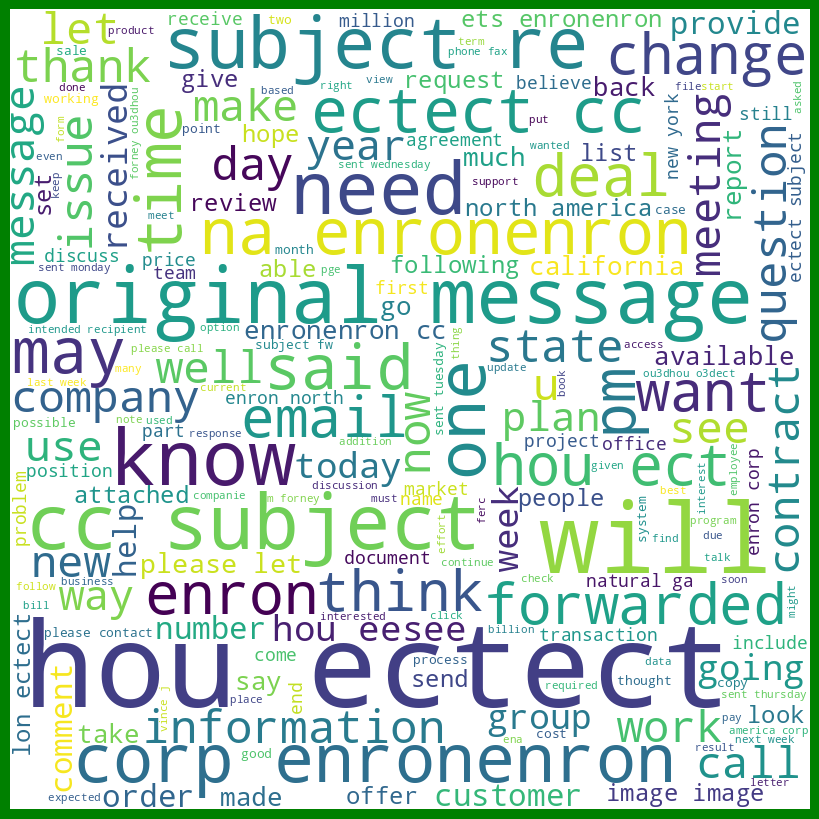

In [89]:
stopwords = set(STOPWORDS) 
  
df_positive = df[df["Sentiment"]== "Positive"] 

positive_words = ' '.join(df_positive.Cleaned_Body.to_list())
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(positive_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = "green") 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

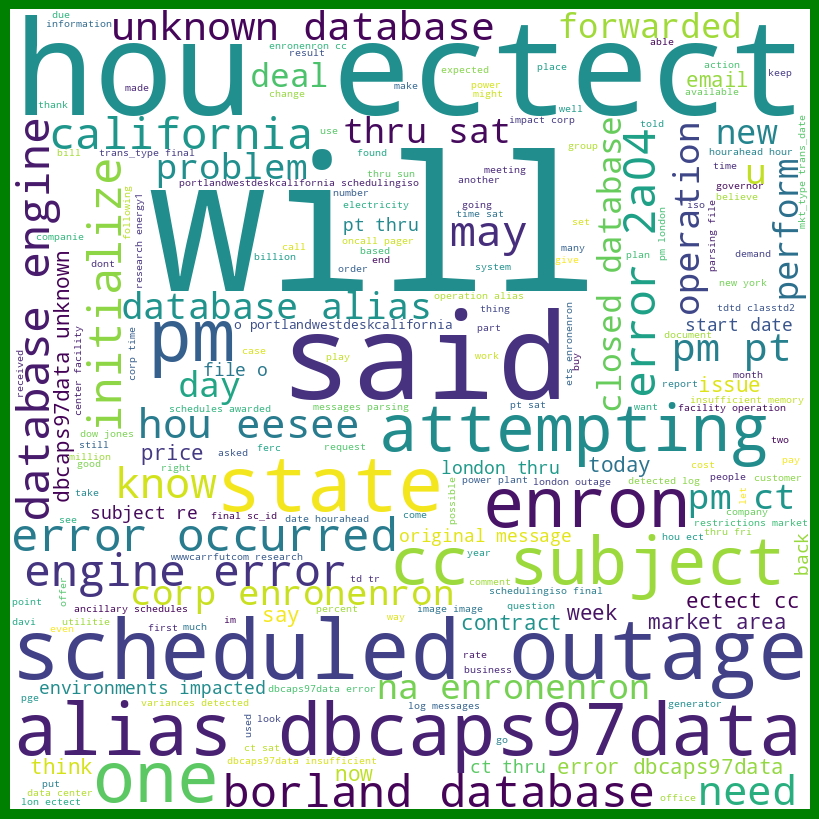

In [90]:
stopwords = set(STOPWORDS) 
  
df_positive = df[df["Sentiment"]== "Negative"] 

negative_words = ' '.join(df_positive.Cleaned_Body.to_list())

  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(negative_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = "green") 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [ ]:
def timeit(func):
    """Decorator to measure the execution time of a function."""
    @wraps(func)
    def time_wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        execution_time = end_time - start_time
        print(f"Function '{func.__name__}' executed in {execution_time:.4f} seconds")
        return result
    return time_wrapper

### 2. RAG

#### Data Prep / Read

In [4]:
# df['subject_plus_body'] = '<<<SUBJECT START>>\n' + df['Subject'] + '<<<\nSUBJECT END>>>\n\n<<<BODY START>>>\n' + df['Body'] + '\n<<<BODY END>>>'

# # Convert the 'Date' column to string format (e.g., 'YYYY-MM-DD')
# df['Date'] = pd.to_datetime(df['Date'], errors='coerce').dt.strftime('%Y-%m-%d')

# df = df[['Date', 'From', 'To', 'To-count', 'subject_plus_body', 'Label', 'Reply', 'Day', 'Month', 'Year', 'Hour',
#        'Minute']]

# df.to_csv(path_or_buf='./email-rag-1L.csv', index=False)

In [22]:
df = pd.read_csv('./email-rag-1L.csv')

In [23]:
df

,Date,From,To,To-count,subject_plus_body,Label,Reply,Day,Month,Year,Hour,Minute
0,2000-06-14,scott.neal@enron.com,sandra.brawner@enron.com,1,<<<SUBJECT START>>\nGas Position Report - Exec...,sent,0,14,6,2000,16,23
1,2000-11-28,connie.blackwood@enron.com,"rebecca.mcdonald@enron.com, wade.cline@enron.c...",5,<<<SUBJECT START>>\nDPC Selldown Meeting<<<\nS...,threads,0,28,11,2000,8,25
2,1999-10-01,spoyneer@haas.berkeley.edu,eveningmba@haas.berkeley.edu,1,<<<SUBJECT START>>\nYour Input Please<<<\nSUBJ...,others,0,1,10,1999,4,46
3,2000-11-07,roger.yang@enron.com,"tamara.johnson@enron.com, marcie.milner@enron....",6,<<<SUBJECT START>>\nCalifornia Rate Changes<<<...,documents,0,7,11,2000,17,49
4,2000-07-25,tana.jones@enron.com,"alan.aronowitz@enron.com, jeffrey.hodge@enron....",10,<<<SUBJECT START>>\nRUSH APPROVAL-Australia + ...,documents,0,25,7,2000,9,53
...,...,...,...,...,...,...,...,...,...,...,...,...
98273,2000-01-05,stinson.gibner@enron.com,information.management@enron.com,1,<<<SUBJECT START>>\nrevision of 1st request<<<...,documents,1,5,1,2000,8,44
98274,2001-11-27,jhairsmd@aol.com,steven.harris@enron.com,1,<<<SUBJECT START>>\n<<<\nSUBJECT END>>>\n\n<<<...,others,1,27,11,2001,20,57
98275,2001-01-02,bible-html@emazing.com,bible-html@emazing.com,1,<<<SUBJECT START>>\nEMAZING Bible Verse of the...,threads,0,2,1,2001,13,50
98276,2000-08-21,bob.shults@enron.com,mark.taylor@enron.com,1,<<<SUBJECT START>>\nEnronOnline Pilot Program<...,inbox,0,21,8,2000,14,20


### 3. Agent

In [24]:
# Initialize the embedding model
embedding_model = OllamaEmbeddings(model="nomic-embed-text")

In [25]:
@timeit
def get_embedding_function():
    # embeddings = BedrockEmbeddings(
    #     credentials_profile_name="default", region_name="us-east-1"
    # )
    embeddings = OllamaEmbeddings(model="nomic-embed-text")
    return embeddings

In [26]:
@timeit
def load_document(df):

    local_df = df.copy().reset_index(drop=False)

    doc = []

    # Process each row in the DataFrame with a progress bar
    for _, row in tqdm(local_df.iterrows(), total=local_df.shape[0]):
        # Create a Document with necessary fields
        document = Document(
            page_content=row['subject_plus_body'],  # Text content for embedding
            id=str(row['index'])  # Unique identifier as string
        )

        meta_data={
            'from': row['From'],
            'to': row['To'], 
            'To-count': row['To-count'],
            'label': row['Label'],
            'date': row['Date'],
            'day': row['Day'],
            'month': row['Month'],
            'year': row['Year'],
            'hour': row['Hour'],
            'minute': row['Minute'],
            'reply': row['Reply']
        }
        
        document.metadata = meta_data

        # Additional meta-data
        doc.append(document)

    return doc

# doc = load_document(df.head())

# print(len(doc))
# doc

In [27]:
@timeit
def split_documents(documents: list[Document]):
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=800,
        chunk_overlap=80,
        length_function=len,
        is_separator_regex=False
    )
    return text_splitter.split_documents(documents)

# chunks = split_documents(doc)
# print(len(chunks))
# chunks

In [28]:
# Initialize Chroma Vector Store
# Assuming vector_db needs to be setup only once
CHROMA_PATH = './db/chroma'

In [29]:
@timeit
def add_to_chroma(chunks: list[Document], CHROMA_PATH):
    # Load the existing database.
    db = Chroma(
        persist_directory=CHROMA_PATH, 
        embedding_function=get_embedding_function()
    )

    print(f"Adding new documents: {len(chunks)}")
    # db.add_documents(new_chunks, ids=new_chunk_ids)
    db.add_documents(chunks)

# try:
#     add_to_chroma(chunks, CHROMA_PATH)
# except Exception as e:
#     print(f"An error occurred: {e}")

In [37]:
docs = load_document(df)
chunks = split_documents(docs)
add_to_chroma(chunks, CHROMA_PATH)

100%|██████████| 98278/98278 [00:11<00:00, 8775.84it/s] 
Function 'load_document' executed in 11.2768 seconds
Function 'split_documents' executed in 10.0743 seconds
Function 'get_embedding_function' executed in 0.0890 seconds
Adding new documents: 339769


In [ ]:
PROMPT_TEMPLATE = """{question}

Answer the above question using below context.

<<< CONTEXT START >>>
{context}
<<< CONTEXT END >>>

<<< CONDITIONS START >>>
1. Answer should be to the point.
2. If you feel the context does not have enough information, say "I don't know".
3. If the question is not related to the context, say "I don't know".
<<< CONDITIONS END >>>
"""

In [31]:
# Prepare the DB.
embedding_function = get_embedding_function()
db = Chroma(persist_directory=CHROMA_PATH, embedding_function=embedding_function)

Function 'get_embedding_function' executed in 0.1863 seconds


In [32]:
# QUERY_TEXT = "How many buildings are there in Delhi?"

# # Search the DB.
# results = db.similarity_search_with_score(QUERY_TEXT, k=3)

# # Prompt Generation
# context_text = "\n\n---\n\n".join([doc.page_content for doc, _score in results])
# prompt_template = ChatPromptTemplate.from_template(PROMPT_TEMPLATE)
# prompt = prompt_template.format(context=context_text, question=QUERY_TEXT)

# # MODEL CALL
# model = OllamaLLM(model="mistral")
# response_text = model.invoke(prompt)

# formatted_response = f'''
# Query: {QUERY_TEXT}

# Response: 
# {'\n'.join(response_text.split('.'))}
# '''

# print(formatted_response)

In [33]:
@timeit
def search_db(db, query_text, k=3):
    """Searches the database for similar documents."""
    return db.similarity_search_with_score(query_text, k=k)

@timeit
def generate_prompt(results, query_text, prompt_template):
    """Generates the prompt for the model."""
    context_text = "\n\n---\n\n".join([doc.page_content for doc, _score in results])
    prompt = prompt_template.format(context=context_text, question=query_text)
    return prompt

@timeit
def model_call(model, prompt):
    """Calls the model with the generated prompt."""
    return model.invoke(prompt)

In [34]:
def get_answer(QUERY_TEXT: str) -> str:
    # Search the DB.
    results = search_db(db, QUERY_TEXT, k=3)

    # Prompt Generation
    prompt = generate_prompt(results, QUERY_TEXT, ChatPromptTemplate.from_template(PROMPT_TEMPLATE))

    # MODEL CALL
    model = OllamaLLM(model="mistral")
    response_text = model_call(model, prompt)

    formatted_response = f'''
    Query: {QUERY_TEXT}

    Response: 
    {'\n'.join(response_text.split('.'))}
    '''

    return formatted_response

In [35]:
answer = get_answer(QUERY_TEXT="Do you know anyting about a scam or fraud happening in our company?")
print(answer)

Function 'search_db' executed in 0.3016 seconds
Function 'generate_prompt' executed in 0.0115 seconds
Function 'model_call' executed in 31.3055 seconds

    Query: Do you know anyting about a scam or fraud happening in our company?

    Response: 
     I don't see any mention of a scam or fraud in the provided context
 To answer your question accurately, I would need more specific information related to your company and the type of fraud you suspect might be happening

    


In [36]:
# Now use the decorated functions
answer = get_answer(QUERY_TEXT="How many buildings are there in Delhi?")
print(answer)

Function 'search_db' executed in 0.9988 seconds
Function 'generate_prompt' executed in 0.0015 seconds
Function 'model_call' executed in 14.3141 seconds

    Query: How many buildings are there in Delhi?

    Response: 
     I don't know without specific data or a reliable source that mentions the total number of buildings in Delhi

    


### 3. Agent

In [ ]:
# Load CSV data into a Pandas DataFrame
csv_file = './email-rag-1L.csv'
df = pd.read_csv(csv_file)

# Create an in-memory SQLite database and load the DataFrame into a table named "emails"
conn = sqlite3.connect(':memory:')
df.to_sql('emails', conn, index=False, if_exists='replace')

98278

In [3]:
pd.read_sql_query("SELECT * FROM emails LIMIT 10", conn)

,Date,From,To,To-count,subject_plus_body,Label,Reply,Day,Month,Year,Hour,Minute
0,2000-06-14,scott.neal@enron.com,sandra.brawner@enron.com,1,<<<SUBJECT START>>\nGas Position Report - Exec...,sent,0,14,6,2000,16,23
1,2000-11-28,connie.blackwood@enron.com,"rebecca.mcdonald@enron.com, wade.cline@enron.c...",5,<<<SUBJECT START>>\nDPC Selldown Meeting<<<\nS...,threads,0,28,11,2000,8,25
2,1999-10-01,spoyneer@haas.berkeley.edu,eveningmba@haas.berkeley.edu,1,<<<SUBJECT START>>\nYour Input Please<<<\nSUBJ...,others,0,1,10,1999,4,46
3,2000-11-07,roger.yang@enron.com,"tamara.johnson@enron.com, marcie.milner@enron....",6,<<<SUBJECT START>>\nCalifornia Rate Changes<<<...,documents,0,7,11,2000,17,49
4,2000-07-25,tana.jones@enron.com,"alan.aronowitz@enron.com, jeffrey.hodge@enron....",10,<<<SUBJECT START>>\nRUSH APPROVAL-Australia + ...,documents,0,25,7,2000,9,53
5,2001-01-05,debra.perlingiere@enron.com,"jeffrey.hodge@enron.com, dan.hyvl@enron.com",2,<<<SUBJECT START>>\n<<<\nSUBJECT END>>>\n\n<<<...,sent,0,5,1,2001,18,1
6,2000-09-11,shari.stack@enron.com,tana.jones@enron.com,1,<<<SUBJECT START>>\nPublic Service Co. of Colo...,documents,0,11,9,2000,15,30
7,2001-06-21,kathy.link@enron.com,b..sanders@enron.com,1,<<<SUBJECT START>>\nRecording of conversations...,inbox,0,21,6,2001,20,38
8,2001-04-14,pete.davis@enron.com,pete.davis@enron.com,1,<<<SUBJECT START>>\nStart Date: 4/14/01; HourA...,documents,0,14,4,2001,22,42
9,2000-11-06,perfmgmt@enron.com,gerald.nemec@enron.com,1,<<<SUBJECT START>>\nYear End 2000 Performance ...,documents,0,6,11,2000,22,50


In [4]:

pd.read_sql_query("SELECT COUNT(*) FROM emails WHERE Year = 2000", conn)

,COUNT(*)
0,37545


In [ ]:
# Initialize your OpenAI LLM (ensure you have set your API key)
# llm = OpenAI(temperature=0, openai_api_key="YOUR_OPENAI_API_KEY")
model = ChatOpenAI(temperature=0)

In [66]:
from langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint, HuggingFacePipeline
from langchain_core.prompts import PromptTemplate

llm = HuggingFaceEndpoint(
    repo_id='google/gemma-2-2b-it',
    task='text_generation', 
)

model = ChatHuggingFace(llm=llm)

In [6]:
# Create a prompt template for converting natural language to SQL.
# Note the table and columns description.
sql_template = PromptTemplate(
    input_variables=["query"],
    template="""
You are an assistant that converts natural language queries into SQL commands.
The database has one table called "emails" with the following columns:
- "Date": The date the email was sent.
- "From": The email address of the sender.
- "To": The email address of the recipient.
- "To-count": The number of recipients.
- "subject_plus_body": The subject and body of the email.
- "Label": Category of the email.
- "Reply": Whether the email is a reply to another email.
- "Day": The day of the week the email was sent.
- "Month": The month the email was sent.
- "Year": The year the email was sent.
- "Hour": The hour the email was sent.
- "Minute": The minute the email was sent.

Rules:
1. Use only the table name "emails" and the column names exactly as listed above.
2. Do not modify, alias, or apply any SQL functions to these column names.
3. Ensure that the SQL query is syntactically correct and executable on the database.
4. Provide only the SQL command without any additional explanation or formatting (i.e., no markdown code blocks).

For example, if the query is "How many emails were sent in year 2022?", the SQL query should be:
SELECT COUNT(*) FROM emails WHERE Year = 2022;

Given the natural language query:
"{query}"

Generate a syntactically correct SQL query that can be executed on this database.
Only provide the SQL command without any explanation.
SQL:"""
)

In [7]:
def execute_sql(sql_command: str):
    """Execute the SQL command on the SQLite database and return the results as a DataFrame."""
    try:
        result = pd.read_sql_query(sql_command, conn)
        status = 1
    except Exception as e:
        result = f"Error executing SQL: {str(e)}"
        status = 0
    return result, status

In [8]:
# Create a prompt template to generate the final natural language answer.
final_template = PromptTemplate(
    input_variables=["query", "result"],
    template="""
You are a helpful assistant tasked with providing a clear answer to a user's query based on SQL query results.

User Query:
"{query}"

SQL Query Result:
{result}

Based on the data provided, generate a concise and informative final answer for the user.
Don't do any string formatting while giving the output
"""
)

In [9]:
# Create a prompt template to generate the final natural language answer.
correct_sql_template = PromptTemplate(
    input_variables=["query", "error", "wrong_sql_command"],
    template = """
The SQL query you previously provided did not execute correctly due to an error. Please correct the SQL query based on the error message and instructions below. You must strictly use the table name and column names exactly as provided, without adding aliases, applying functions, or modifying them.

User Query:
"{query}"

Previous SQL Command that produced an error:
{wrong_sql_command}

Error Message:
{error}

The database has one table called "emails" with the following columns:
- "Date": The date the email was sent.
- "From": The email address of the sender.
- "To": The email address of the recipient.
- "To-count": The number of recipients.
- "subject_plus_body": The subject and body of the email.
- "Label": Category of the email.
- "Reply": Whether the email is a reply to another email.
- "Day": The day of the week the email was sent.
- "Month": The month the email was sent.
- "Year": The year the email was sent.
- "Hour": The hour the email was sent.
- "Minute": The minute the email was sent.

Rules:
1. Use only the table name "emails" and the column names exactly as listed above.
2. Do not modify, alias, or apply any SQL functions to these column names.
3. Ensure that the SQL query is syntactically correct and executable on the database.
4. Provide only the SQL command without any additional explanation or formatting (i.e., no markdown code blocks).

Example:
For the user query "How many emails were sent in year 2022?", the correct SQL query should be:
SELECT COUNT(*) FROM emails WHERE Year = 2022;

Now, based on the above instructions and the provided information, generate a corrected SQL query for the user query.
"""
)

In [10]:
import re

def extract_sql(query_content: str) -> str:
    # Regex pattern to match text between ```sql and ```
    pattern = r'```sql\s*(.*?)\s*```'
    match = re.search(pattern, query_content, re.DOTALL)
    if match:
        # Return the captured SQL query text
        return match.group(1).strip()
    # If no markdown formatting is found, return the original string stripped
    return query_content.strip()

In [19]:
def main(query):

    # Print query
    print(f'Query: {query}')

    # Create the LangChain LLMChain for SQL generation
    sql_chain = sql_template | model

    result_sql_command = sql_chain.invoke({'query': query})
    print('\nSQL Query Result/Generated SQL command:')
    print(result_sql_command.content)

    sql_command_parsed = extract_sql(result_sql_command.content)

    # Execute the generated SQL command on the database.
    result, status = execute_sql(sql_command_parsed)

    run_count = 1
    while status==0:
        print(f"SQL Query fail: [{run_count}]: {sql_command_parsed}")
        run_count += 1

        sql_correction_chain = correct_sql_template | model
        result_new_sql_command = sql_correction_chain.invoke({
            'query': query, 
            'wrong_sql_command': sql_command_parsed,
            'error': result
        })

        sql_command_parsed = extract_sql(result_new_sql_command.content)
        result, status = execute_sql(sql_command_parsed)

        if run_count == 4:
            print('\n[!] Correction for SQL query limit reached')
            break
        

    print("\nSQL execution result: ", result)

    # Create the LangChain LLMChain for synthesizing the final answer.
    final_chain = final_template | model

    final_answer = final_chain.invoke({'query': query, 'result': result})
    final_answer = final_answer.content.strip()
    print("\nFinal answer: ", final_answer)

In [12]:
main('Count of emails in year 2000')

Query: Count of emails in year 2000

SQL Query Result/Generated SQL command: content='SELECT COUNT(*) FROM emails WHERE Year = 2000;' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 332, 'total_tokens': 345, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None} id='run-478cc5a8-5d8a-467e-8cf4-d6767fd67442-0' usage_metadata={'input_tokens': 332, 'output_tokens': 13, 'total_tokens': 345, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}

SQL execution result:     COUNT(*)
0     37545

Final answer:  The count of emails in the year 2000 is 37545.


In [120]:
main('Count of emails in year 2000')

Query: Count of emails in year 2000

SQL Query Result/Generated SQL command: content='SELECT COUNT(*) FROM emails WHERE Year = 2000; \n' additional_kwargs={} response_metadata={'token_usage': ChatCompletionOutputUsage(completion_tokens=17, prompt_tokens=184, total_tokens=201), 'model': '', 'finish_reason': 'stop'} id='run-567c1dc9-a613-4fb4-931c-07765bc5fb95-0'

SQL execution result:     COUNT(*)
0     37545

Final answer:  There were 37,545 emails in the year 2000.


In [14]:
main('Tell me how many email exchanges are done each year?')

Query: Tell me how many email exchanges are done each year?

SQL Query Result/Generated SQL command: content='SELECT COUNT(*) FROM emails WHERE Reply = 1 GROUP BY Year;' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 334, 'total_tokens': 349, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None} id='run-327419a8-d266-4a43-a5e8-e7e6b4e312c2-0' usage_metadata={'input_tokens': 334, 'output_tokens': 15, 'total_tokens': 349, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}

SQL execution result:     COUNT(*)
0        26
1        14
2       682
3     12214
4     15281
5      1518

Final answer:  The number of email

In [15]:
main('Count of emails sent every year')

Query: Count of emails sent every year

SQL Query Result/Generated SQL command: content='SELECT Year, COUNT(*) FROM emails GROUP BY Year;' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 330, 'total_tokens': 342, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None} id='run-eedc8077-f868-4ad5-bbf7-090fe6e4ddd3-0' usage_metadata={'input_tokens': 330, 'output_tokens': 12, 'total_tokens': 342, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}

SQL execution result:     Year  COUNT(*)
0  1980        63
1  1998        33
2  1999      2151
3  2000     37545
4  2001     51488
5  2002      6983
6  2004        13
7  200

In [16]:
main('Who sent the maximum emails?')

Query: Who sent the maximum emails?

SQL Query Result/Generated SQL command: content='SELECT "From", COUNT(*) AS email_count\nFROM emails\nGROUP BY "From"\nORDER BY email_count DESC\nLIMIT 1;' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 329, 'total_tokens': 358, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None} id='run-3a5555bf-2416-4299-aa39-04773af06167-0' usage_metadata={'input_tokens': 329, 'output_tokens': 29, 'total_tokens': 358, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}

SQL execution result:                   From  email_count
0  kay.mann@enron.com         3203

Final answer:  The user w

In [21]:
main('Who received the maximum number of emails?')

Query: Who received the maximum number of emails?

SQL Query Result/Generated SQL command:
SELECT "To", SUM("To-count") AS total_emails_received
FROM emails
GROUP BY "To"
ORDER BY total_emails_received DESC
LIMIT 1;

SQL execution result:                                                    To  total_emails_received
0  aaron.adams@enron.com, ana.agudelo@enron.com, ...                   6360

Final answer:  The recipient who received the maximum number of emails is aaron.adams@enron.com, ana.agudelo@enron.com, and others, with a total of 6360 emails received.


In [20]:
df

,Date,From,To,To-count,subject_plus_body,Label,Reply,Day,Month,Year,Hour,Minute
0,2000-06-14,scott.neal@enron.com,sandra.brawner@enron.com,1,<<<SUBJECT START>>\nGas Position Report - Exec...,sent,0,14,6,2000,16,23
1,2000-11-28,connie.blackwood@enron.com,"rebecca.mcdonald@enron.com, wade.cline@enron.c...",5,<<<SUBJECT START>>\nDPC Selldown Meeting<<<\nS...,threads,0,28,11,2000,8,25
2,1999-10-01,spoyneer@haas.berkeley.edu,eveningmba@haas.berkeley.edu,1,<<<SUBJECT START>>\nYour Input Please<<<\nSUBJ...,others,0,1,10,1999,4,46
3,2000-11-07,roger.yang@enron.com,"tamara.johnson@enron.com, marcie.milner@enron....",6,<<<SUBJECT START>>\nCalifornia Rate Changes<<<...,documents,0,7,11,2000,17,49
4,2000-07-25,tana.jones@enron.com,"alan.aronowitz@enron.com, jeffrey.hodge@enron....",10,<<<SUBJECT START>>\nRUSH APPROVAL-Australia + ...,documents,0,25,7,2000,9,53
...,...,...,...,...,...,...,...,...,...,...,...,...
98273,2000-01-05,stinson.gibner@enron.com,information.management@enron.com,1,<<<SUBJECT START>>\nrevision of 1st request<<<...,documents,1,5,1,2000,8,44
98274,2001-11-27,jhairsmd@aol.com,steven.harris@enron.com,1,<<<SUBJECT START>>\n<<<\nSUBJECT END>>>\n\n<<<...,others,1,27,11,2001,20,57
98275,2001-01-02,bible-html@emazing.com,bible-html@emazing.com,1,<<<SUBJECT START>>\nEMAZING Bible Verse of the...,threads,0,2,1,2001,13,50
98276,2000-08-21,bob.shults@enron.com,mark.taylor@enron.com,1,<<<SUBJECT START>>\nEnronOnline Pilot Program<...,inbox,0,21,8,2000,14,20


In [22]:
main('What is the percentage of each label in the entire table?')

Query: What is the percentage of each label in the entire table?

SQL Query Result/Generated SQL command:
SELECT Label, COUNT(*) * 100.0 / (SELECT COUNT(*) FROM emails) AS Percentage
FROM emails
GROUP BY Label;

SQL execution result:         Label  Percentage
0  documents   24.831600
1      inbox   15.352368
2     others   23.760150
3       sent   24.693217
4    threads   11.362665

Final answer:  The percentage of each label in the entire table is as follows:
- documents: 24.831600%
- inbox: 15.352368%
- others: 23.760150%
- sent: 24.693217%
- threads: 11.362665%


In [23]:
main('Give me email ids of those people who have marked more than 10 receipients in a single email')

Query: Give me email ids of those people who have marked more than 10 receipients in a single email

SQL Query Result/Generated SQL command:
SELECT "From" FROM emails WHERE "To-count" > 10;

SQL execution result:                                 From
0           cheryl.nelson@enron.com
1            kathy.dodgen@enron.com
2          shelley.corman@enron.com
3        michelle.lawless@enron.com
4              kaye.ellis@enron.com
...                             ...
9162         amanda.huble@enron.com
9163  mark.gershon@piperrudnick.com
9164            l..denton@enron.com
9165         janet.butler@enron.com
9166           liz.taylor@enron.com

[9167 rows x 1 columns]

Final answer:  The email ids of people who have marked more than 10 recipients in a single email are not available in the SQL query result provided.


In [24]:
main('Give me email ids of those people who have marked more than 10 receipients in a single email and whose email id starts with "m"')

Query: Give me email ids of those people who have marked more than 10 receipients in a single email and whose email id starts with "m"

SQL Query Result/Generated SQL command:
SELECT "From" FROM emails WHERE To-count > 10 AND "From" LIKE 'm%';
SQL Query fail: [1]: SELECT "From" FROM emails WHERE To-count > 10 AND "From" LIKE 'm%';

SQL execution result:                                From
0       michelle.lawless@enron.com
1            mary.schoen@enron.com
2          miyung.buster@enron.com
3          miyung.buster@enron.com
4            mark.lavine@enron.com
..                             ...
828       mike.mccracken@enron.com
829        miyung.buster@enron.com
830          marie.heard@enron.com
831         miki.bode@williams.com
832  mark.gershon@piperrudnick.com

[833 rows x 1 columns]

Final answer:  The email ids of people who have marked more than 10 recipients in a single email and whose email id starts with "m" are:
- michelle.lawless@enron.com
- mary.schoen@enron.com
- miyung

In [26]:
main("How many emails did mary.schoen@enron.com send and receive?")

Query: How many emails did mary.schoen@enron.com send and receive?

SQL Query Result/Generated SQL command:
SELECT COUNT(*) FROM emails WHERE "From" = 'mary.schoen@enron.com' OR "To" = 'mary.schoen@enron.com';

SQL execution result:     COUNT(*)
0        15

Final answer:  Mary Schoen sent and received a total of 15 emails.


In [27]:
main("How many emails did mary.schoen@enron.com send?")

Query: How many emails did mary.schoen@enron.com send?

SQL Query Result/Generated SQL command:
SELECT COUNT(*) FROM emails WHERE "From" = 'mary.schoen@enron.com';

SQL execution result:     COUNT(*)
0        13

Final answer:  The user mary.schoen@enron.com sent a total of 13 emails.


In [28]:
main("How many emails did mary.schoen@enron.com receive?")

Query: How many emails did mary.schoen@enron.com receive?

SQL Query Result/Generated SQL command:
SELECT COUNT(*) FROM emails WHERE To = 'mary.schoen@enron.com';
SQL Query fail: [1]: SELECT COUNT(*) FROM emails WHERE To = 'mary.schoen@enron.com';

SQL execution result:     COUNT(*)
0         2

Final answer:  Mary.schoen@enron.com received 2 emails.


In [29]:
main("Who sent the maximum number of emails?")

Query: Who sent the maximum number of emails?

SQL Query Result/Generated SQL command:
SELECT "From", COUNT(*) AS email_count
FROM emails
GROUP BY "From"
ORDER BY email_count DESC
LIMIT 1;

SQL execution result:                   From  email_count
0  kay.mann@enron.com         3203

Final answer:  The user who sent the maximum number of emails is kay.mann@enron.com with a total of 3203 emails sent.


### 4. Synthetic data generation

In [3]:
# Load CSV data into a Pandas DataFrame
csv_file = './email-rag-1L.csv'
df = pd.read_csv(csv_file)

# Create an in-memory SQLite database and load the DataFrame into a table named "emails"
conn = sqlite3.connect(':memory:')
df.to_sql('emails', conn, index=False, if_exists='replace')

98278

In [67]:
# Initialize your OpenAI LLM (ensure you have set your API key)
# llm = OpenAI(temperature=0, openai_api_key="YOUR_OPENAI_API_KEY")
model_openai = ChatOpenAI(temperature=0)

In [5]:
from langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint, HuggingFacePipeline
from langchain_core.prompts import PromptTemplate

llm = HuggingFaceEndpoint(
    repo_id='google/gemma-2-2b-it',
    task='text_generation', 
)

model = ChatHuggingFace(llm=llm)

In [ ]:
# Create a prompt template to generate the final natural language answer.
template_generate_synthetic_email = PromptTemplate(
    input_variables=["reference_email"],
    template="""
You are expert in generating Cross-Domain Synthetic Email given an email.

Randomly select a sector from: [Renewable Energy | Healthcare | Agriculture | Automotive | Fintech | Pharma]. 
Take reference from the given email and generate a synthetic email in that sector.

Generate a synthetic email by:

1. Sector-Specific Substitutions:
    1.1. Company: [Sector] Corp (e.g., 'AgriCorp India' for Agriculture)
    1.2. Email domains: @[sectorkeyword]company.com (e.g., @healthcompany.com)
    1.3. Currency: [Sector-appropriate] (₹ for India, € for EU pharma, etc.)
    1.4. Locations: [Sector-relevant] (Wind farms in Texas for Energy, clinical sites for Pharma)
    1.5. Roles: [CTO for Tech | CFO for Fintech | Head Grower for Agriculture]

2. Apply These Transformations:
    2.1. Replace all names/contacts with culturally appropriate fictional equivalents
    2.2. Convert financial/metrics to sector units (MW for energy, patient count for healthcare)
    2.3. Insert 2-3 industry-specific attachments (e.g., 'Phase III Trial Report' for Pharma)

3. Mandatory Guardrails:
    3.1. Never mix elements across sectors (e.g., no "pharma supply chain" in fintech emails)
    3.2. Use only fictional company names from approved list: [Sector]Corp, [Sector]Global, Green[Sector]
    3.3. All email IDs must match domain pattern @[sectorkeyword]company.com
    3.4. Include 1 regulatory reference (GDPR/HIPAA/ISO standards) where appropriate
    3.5. Do not apply any formatting to the output like bold/italic/underline
    3.6. Ensure the email is in English language only
    3.7. Ensure not to add any fillers like [sector-specific details] instead expand it and generate real data
    3.8. Do not add any links in the email
    3.9. Do not add any attachments in the email
    3.10. Do not add any images in the email
    3.11. Do not add any tables in the email
    3.12. Do not add any footnotes in the email
    3.15. Make sure the name in Salutation do match with the email ID used in the "To" section of the email.

[Reference EMAIL]
{reference_email}
    
[Example Output Structure (Agriculture Sector)]
From: rahul.mehta@agcompany.com
To: rahul.verma@agcompany.com | priya.shah@agcompany.com
Date: 06/09/2000 02:08 PM
Subject: Approval of Hybrid Seed Procurement Contract
Dear Priya,
Per our discussion, attached is the MoU for sourcing 25,000 kg of drought-resistant wheat seeds from FarmGen Innovations (managed by Mr. Vikram Reddy). This ₹4.2 crore deal includes... [sector-specific details]...
Awaiting FSSAI compliance certification before finalizing. CC: Regional Procurement Team.
Generate email following EXACTLY this pattern for your randomly chosen sector.
"""
)

In [ ]:
You are expert in generating Cross-Domain Synthetic Email given an email.

Randomly select a sector from: [Renewable Energy | Healthcare | Agriculture | Automotive | Fintech | Pharma]. 
Take reference from the given email and generate a synthetic email in that sector.

Generate a synthetic email by:

1. Sector-Specific Substitutions:
    1.1. Company: [Sector] Corp (e.g., 'AgriCorp India' for Agriculture)
    1.2. Email domains: @[sectorkeyword]company.com (e.g., @healthcompany.com)
    1.3. Currency: [Sector-appropriate] (₹ for India, € for EU pharma, etc.)
    1.4. Locations: [Sector-relevant] (Wind farms in Texas for Energy, clinical sites for Pharma)
    1.5. Roles: [CTO for Tech | CFO for Fintech | Head Grower for Agriculture]

2. Apply These Transformations:
    2.1. Replace all names/contacts with culturally appropriate fictional equivalents
    2.2. Convert financial/metrics to sector units (MW for energy, patient count for healthcare)
    2.3. Insert 2-3 industry-specific attachments (e.g., 'Phase III Trial Report' for Pharma)

3. Mandatory Guardrails:
    3.1. Never mix elements across sectors (e.g., no "pharma supply chain" in fintech emails)
    3.2. Use only fictional company names from approved list: [Sector]Corp, [Sector]Global, Green[Sector]
    3.3. All email IDs must match domain pattern @[sectorkeyword]company.com
    3.4. Include 1 regulatory reference (GDPR/HIPAA/ISO standards) where appropriate

Example Output Structure (Agriculture Sector):
| rahul.mehta@agcompany.com | priya.shah@agcompany.com | 2024-07-15 14:30:00 |
Subject: Approval of Hybrid Seed Procurement Contract
Dear Priya,
Per our discussion, attached is the MoU for sourcing 25,000 kg of drought-resistant wheat seeds from FarmGen Innovations (managed by Mr. Vikram Reddy). This ₹4.2 crore deal includes... [sector-specific details]...
Awaiting FSSAI compliance certification before finalizing. CC: Regional Procurement Team.
Generate email following EXACTLY this pattern for your randomly chosen sector.
    
[Reference EMAIL]
{reference_email}

In [36]:
def structure_email(row):
    from_ = row['From']
    to_ = row['To']
    date_ = row['Date']
    subject_body = row['subject_plus_body']

    subject = subject_body.split("<<<\nSUBJECT END>>>")[0].replace("<<<SUBJECT START>>", "").strip()
    body = subject_body.split("<<<BODY START>>>")[1].replace("<<<BODY END>>>", "").strip()

    return f"From: {from_}\nTo: {to_}\nDate: {date_}\nSubject: {subject}\n\n{body}\n"

df['email_structured'] = df.apply(lambda row: structure_email(row), axis=1)

In [62]:
reference_email = df.loc[50, 'email_structured']

chain_generate_synthetic_email = template_generate_synthetic_email | model
result_generate_synthetic_email = chain_generate_synthetic_email.invoke({'reference_email': reference_email})

print(reference_email)
print('\n\n', end='#'*100)
print('\n\n')
print(result_generate_synthetic_email.content)

From: robert.johnston@enron.com
To: greg.whalley@enron.com, gary.hickerson@enron.com
Date: 2001-05-23
Subject: California 5/23

There will be a press conference by the Assembly Republicans at 10:30 a.m. 
PDT to announce their counter-proposal to the MOU.  This should give further 
insight and generate market reaction as to whether SoCal can be saved.  The 
Republicans are almost certain to offer something less generous that the 
original Davis transmission line offer.



####################################################################################################


From: ceo.landry@invenergi.com
To: ceo.cooper@invenergi.com, gina.wilson@invenergi.com
Date: 11/13/2023 13:58 PM
Subject: Wind Farm Deployment Update

Dear Gina,
Please find attached the updated feasibility study in regards to our East Coast wind farm project. After analyzing the site and local stakeholder engagement, we conclude it is feasible to move forward. The project will allow us to meet the renewable energy ob

In [63]:
# Create a prompt template to generate the final natural language answer.
template_generate_synthetic_email2 = PromptTemplate(
    input_variables=["reference_email"],
    template="""
Transform the following Enron-style transaction email into a completely synthetic email that reflects a real-world corporate communication from a different industry. Change all specific names, email addresses, company names, timestamps, monetary values, and contact details. The synthetic email should include:

1. A realistic header with sender and recipient email addresses and a timestamp.
2. A clear subject line indicating a transaction or approval (e.g., 'Approval of the Accelerated Transaction' or 'Authorization of the Strategic Deal', etc.).
3. A detailed email body describing a financial, strategic, or operational transaction, including references to supporting documents, involved team members, and next steps for review.
4. Industry-specific details tailored to a chosen sector (e.g., technology, healthcare, manufacturing, or finance).
5. A narrative that retains the complexity and variability of real enterprise data while ensuring all sensitive information is fully de-identified. The final email should look like an authentic communication from a corporate environment and be suitable for fine-tuning downstream LLMs for tasks like classification.
6. Roles: [CTO for Tech, CFO for Fintech, Head Grower for Agriculture, etc]

7. Apply These Transformations:
    2.1. Replace all names/contacts with culturally appropriate fictional equivalents
    2.2. Convert financial/metrics to sector units (MW for energy, patient count for healthcare)
    2.3. Insert 2-3 industry-specific attachments (e.g., 'Phase III Trial Report' for Pharma)

8. Mandatory Guardrails:
    3.1. Never mix elements across sectors (e.g., no "pharma supply chain" in fintech emails)
    3.2. Use only fictional company names from approved list: [Sector]Corp, [Sector]Global, Green[Sector]
    3.3. All email IDs must match domain pattern @[sectorkeyword]company.com
    3.4. Include 1 regulatory reference (GDPR/HIPAA/ISO standards) where appropriate
    3.5. Do not apply any formatting to the output like bold/italic/underline
    3.6. Ensure the email is in English language only
    3.7. Ensure not to add any fillers like [sector-specific details] instead expand it and generate real data
    3.8. Do not add any links in the email
    3.9. Do not add any attachments in the email
    3.10. Do not add any images in the email
    3.11. Do not add any tables in the email
    3.15. Make sure the name in Salutation do match with the email ID used in the "To" section of the email.

[Reference EMAIL]
{reference_email}
    
[Example Output Structure (Agriculture Sector)]
From: rahul.mehta@agcompany.com
To: rahul.verma@agcompany.com | priya.shah@agcompany.com
Date: 06/09/2000 02:08 PM
Subject: Approval of Hybrid Seed Procurement Contract
Dear Priya,
Per our discussion, attached is the MoU for sourcing 25,000 kg of drought-resistant wheat seeds from FarmGen Innovations (managed by Mr. Vikram Reddy). This ₹4.2 crore deal includes... [sector-specific details]...
Awaiting FSSAI compliance certification before finalizing. CC: Regional Procurement Team.
Generate email following EXACTLY this pattern for your randomly chosen sector.
"""
)

In [64]:
reference_email = df.loc[50, 'email_structured']

chain_generate_synthetic_email2 = template_generate_synthetic_email2 | model
result_generate_synthetic_email2 = chain_generate_synthetic_email2.invoke({'reference_email': reference_email})

print(reference_email)
print('\n\n', end='#'*100)
print('\n\n')
print(result_generate_synthetic_email2.content)

From: robert.johnston@enron.com
To: greg.whalley@enron.com, gary.hickerson@enron.com
Date: 2001-05-23
Subject: California 5/23

There will be a press conference by the Assembly Republicans at 10:30 a.m. 
PDT to announce their counter-proposal to the MOU.  This should give further 
insight and generate market reaction as to whether SoCal can be saved.  The 
Republicans are almost certain to offer something less generous that the 
original Davis transmission line offer.



####################################################################################################


From: david.brown@circuitco.com
To: olivia.davis@circuitco.com,michael.rogers@circuitco.com 
Date: 2023-11-15 10:01 PM
Subject: Authorization of the Strategic EPCM Contract

Dear Olivia,

Per our discussion, please find attached the Memorandum of Understanding for the  EPC project with AV Integrated Solutions, an establishment no. 6786,  Pune. This contract involves services including:
 * Phase III Trial Report: AV In

In [68]:

reference_email = df.loc[50, 'email_structured']

chain_generate_synthetic_email2 = template_generate_synthetic_email2 | model_openai
result_generate_synthetic_email2 = chain_generate_synthetic_email2.invoke({'reference_email': reference_email})

print(reference_email)
print('\n\n', end='#'*100)
print('\n\n')
print(result_generate_synthetic_email2.content)

From: robert.johnston@enron.com
To: greg.whalley@enron.com, gary.hickerson@enron.com
Date: 2001-05-23
Subject: California 5/23

There will be a press conference by the Assembly Republicans at 10:30 a.m. 
PDT to announce their counter-proposal to the MOU.  This should give further 
insight and generate market reaction as to whether SoCal can be saved.  The 
Republicans are almost certain to offer something less generous that the 
original Davis transmission line offer.



####################################################################################################


From: sarah.nguyen@techglobal.com
To: alex.tran@techglobal.com | emily.nguyen@techglobal.com
Date: 10/15/2022 09:45 AM
Subject: Approval of Software Development Project

Dear Alex,

Following our recent meeting, please find attached the proposal for the development of a new AI-driven customer relationship management system by CodeInnovate Solutions. This project is estimated to cost 500,000 MW and is expected to enhan

In [69]:

reference_email = df.loc[1000, 'email_structured']

chain_generate_synthetic_email2 = template_generate_synthetic_email2 | model_openai
result_generate_synthetic_email2 = chain_generate_synthetic_email2.invoke({'reference_email': reference_email})

print(reference_email)
print('\n\n', end='#'*100)
print('\n\n')
print(result_generate_synthetic_email2.content)

From: farhad.ahad@enron.com
To: vince.kaminski@enron.com
Date: 2000-05-22
Subject: Exmar Deal

Dear Vince,
This is the final version of the DASH that was presented to Jeff and Joe on 
Friday.  Please let me know if I can be of more help.
Best Regards,
Farhad Ahad






Vince J Kaminski@ECT
05/16/2000 01:34 PM
To: Farhad Ahad/Corp/Enron@ENRON
cc: John Sherriff/LON/ECT@ECT, Vince J Kaminski/HOU/ECT@ECT, Stinson 
Gibner/HOU/ECT@ECT, David Gorte/HOU/ECT@ECT 

Subject: Exmar Deal

Farhad,

Please, cc-mail to John Sherriff in London the DASH  of the EXMAR transaction 
when it becomes official.


Vince



####################################################################################################


From: amit.sharma@greentechcompany.com
To: priya.joshi@greentechcompany.com | rahul.patel@greentechcompany.com
Date: 10/15/2021 09:30 AM
Subject: Authorization of Solar Panel Installation Project

Dear Priya,

Following our recent meeting, please find attached the proposal for the installat

In [ ]:
df_100_samples = df.sample(100)
df_100_samples.reset_index(drop=True, inplace=True)

In [ ]:
df_100_samples['synthetic_email'] = df_100_samples['email_structured'].apply(lambda x: chain_generate_synthetic_email2.invoke({'reference_email': x}))

In [76]:
df_100_samples['synthetic_emal'] = df_100_samples['synthetic_emal'].apply(lambda x: x.content)

In [73]:
df_100_samples

,Date,From,To,To-count,subject_plus_body,Label,Reply,Day,Month,Year,Hour,Minute,email_structured,synthetic_emal
22291,2001-05-16,maureen.mcvicker@enron.com,"alex.goldberg@williams.com, bbailey@duke-energ...",18,<<<SUBJECT START>>\nNEW DIAL IN # FOR FRI CONF...,others,0,16,5,2001,17,30,From: maureen.mcvicker@enron.com\nTo: alex.gol...,content='From: john.smith@techglobal.com\nTo: ...
90812,2001-06-26,j.kaminski@enron.com,vkaminski@aol.com,1,<<<SUBJECT START>>\nFW: Venezuela FX and infla...,sent,0,26,6,2001,16,40,From: j.kaminski@enron.com\nTo: vkaminski@aol....,content='[Synthetic Email]\n\nFrom: sarah.nguy...
7856,2001-06-01,eric.thode@enron.com,"mark.frevert@enron.com, greg.whalley@enron.com...",4,<<<SUBJECT START>>\nSkilling Floor Meeting<<<\...,threads,0,1,6,2001,8,50,From: eric.thode@enron.com\nTo: mark.frevert@e...,"content=""From: alex.wong@techglobal.com\nTo: e..."
47737,2001-10-18,no.address@enron.com,Houston Outage Report@ENRON,1,<<<SUBJECT START>>\nWeekend Outage Report for ...,others,0,18,10,2001,21,26,From: no.address@enron.com\nTo: Houston Outage...,content='From: john.smith@manufacturingglobal....
70664,2002-01-09,beth.perlman@enron.com,"louise.kitchen@enron.com, greg.piper@enron.com...",3,<<<SUBJECT START>>\nConfusion Around Treasury ...,others,0,9,1,2002,15,44,From: beth.perlman@enron.com\nTo: louise.kitch...,content='[Synthetic Email]\n\nFrom: alex.wong@...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46173,2000-11-30,kate.symes@enron.com,elliot.mainzer@enron.com,1,<<<SUBJECT START>>\nBlazers v. Dallas<<<\nSUBJ...,sent,0,30,11,2000,12,51,From: kate.symes@enron.com\nTo: elliot.mainzer...,content='[Synthetic Email]\n\nFrom: alex.wong@...
40316,2001-11-19,barry.tycholiz@enron.com,jeanie.slone@enron.com,1,<<<SUBJECT START>>\nFW: Heidi Dubose Performan...,sent,0,19,11,2001,17,38,From: barry.tycholiz@enron.com\nTo: jeanie.slo...,content='From: sarah.jones@techglobal.com\nTo:...
21749,2002-01-08,clearbot@clearmail2.etrade.com,kensey_subscriber@mailman.enron.com,1,<<<SUBJECT START>>\n(ClearStation) Recommendat...,others,0,8,1,2002,5,44,From: clearbot@clearmail2.etrade.com\nTo: kens...,content='From: john.smith@manufacturingcorp.co...
38056,2002-01-16,pete.davis@enron.com,pete.davis@enron.com,1,<<<SUBJECT START>>\nSchedule Crawler: HourAhea...,others,0,16,1,2002,9,36,From: pete.davis@enron.com\nTo: pete.davis@enr...,content='From: alex.wong@techglobal.com\nTo: e...


In [78]:
df_100_samples.loc[:, ['email_structured', 'synthetic_emal']]

,email_structured,synthetic_emal
22291,From: maureen.mcvicker@enron.com\nTo: alex.gol...,From: john.smith@techglobal.com\nTo: emily.jon...
90812,From: j.kaminski@enron.com\nTo: vkaminski@aol....,[Synthetic Email]\n\nFrom: sarah.nguyen@techgl...
7856,From: eric.thode@enron.com\nTo: mark.frevert@e...,From: alex.wong@techglobal.com\nTo: emily.ng@t...
47737,From: no.address@enron.com\nTo: Houston Outage...,From: john.smith@manufacturingglobal.com\nTo: ...
70664,From: beth.perlman@enron.com\nTo: louise.kitch...,[Synthetic Email]\n\nFrom: alex.wong@techgloba...
...,...,...
46173,From: kate.symes@enron.com\nTo: elliot.mainzer...,[Synthetic Email]\n\nFrom: alex.wong@techgloba...
40316,From: barry.tycholiz@enron.com\nTo: jeanie.slo...,From: sarah.jones@techglobal.com\nTo: chris.sm...
21749,From: clearbot@clearmail2.etrade.com\nTo: kens...,From: john.smith@manufacturingcorp.com\nTo: em...
38056,From: pete.davis@enron.com\nTo: pete.davis@enr...,From: alex.wong@techglobal.com\nTo: emily.ng@t...


In [77]:
df_100_samples.to_csv('synthetic_email_data.csv', index=False)